In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Load the general math/data manipulation packages

In [2]:
import numpy as np
import pandas as pd

Load the packages related to the Gaussian Process Regressor:

In [3]:
import gpflow
import tensorflow as tf

In [4]:
from gpflow.utilities import print_summary

In [5]:
gpflow.config.set_default_summary_fmt("notebook")

In [6]:
tf.config.set_visible_devices([], 'GPU')

In [7]:
import matplotlib.pyplot as plt

Load the CasADi package used for optimization:

In [8]:
import casadi

Import MATLAB engine and start it in the background since this takes a while:

In [9]:
import matlab.engine

In [10]:
eng = matlab.engine.start_matlab()

In [11]:
eng.load_system("../Simulink/polydome", background = True)

Copy the experimental data set to the CARNOT input location: 

In [12]:
exp_id = 'Exp5'

In [13]:
copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")

'../Data/input_WDB.mat'

## Load the existing GP model

In [14]:
model_path = Path(Path.cwd(), 'model')

In [15]:
def load_gpr(model_path):
    x_scaler = pickle.load(open(Path(model_path, 'x_scaler.pkl'), 'rb'))
    m_params = pickle.load(open(Path(model_path, 'gp_params.gpf'), 'rb'))
    m_data = pickle.load(open(Path(model_path, 'gp_data.gpf'), 'rb'))

    k = gpflow.kernels.SquaredExponential(lengthscales=([1] * m_data[0].shape[1])) + gpflow.kernels.Constant()

    m = gpflow.models.GPR(
        data = m_data, 
        kernel = k, 
        mean_function = None
        )
    
    gpflow.utilities.multiple_assign(m, m_params)
    
    return x_scaler, m

In [16]:
x_scaler, model = load_gpr(model_path)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,284790.175758825
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[8.23155895e+04, 1.32876975e+05, 2.21167354e+02..."
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,220815.62255492577
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.1263230455247145


In [85]:
def get_gpr_horizon_array(W, x0, u):
    
    n_rows = W.shape[0]
    
    n_w = W.shape[1]
    n_inputs = u.shape[1]
    n_cols = n_w + n_inputs + x0.shape[1]
    
    X = np.zeros([n_rows, n_cols])
    X[:, :2] = W
    X[0, (n_w + n_inputs):] = x0
    X[:, 2] = u.reshape((-1,))
    
    # autoregressive inputs
    X[1: , 3] = X[:-1, 2]
    
    for idx in range(1, n_rows):
        x_sc = x_scaler.transform(X[idx-1, :].reshape((1, -1)))
        X[idx, 4], _ = model.predict_y(x_sc)
        X[idx, 5:] = X[idx -1, 4:-1]
        
    return X

In [86]:
test_W = np.ones([5, 2])
test_x0 = 2 * np.ones([1, 4])
test_u0 = 3 * np.ones([5, 1])

test_X = get_gpr_horizon_array(test_W, test_x0, test_u0)
test_X

array([[ 1.        ,  1.        ,  3.        ,  2.        ,  2.        ,
         2.        ,  2.        ],
       [ 1.        ,  1.        ,  3.        ,  3.        ,  3.16887448,
         2.        ,  2.        ],
       [ 1.        ,  1.        ,  3.        ,  3.        ,  6.02687796,
         3.16887448,  2.        ],
       [ 1.        ,  1.        ,  3.        ,  3.        , 11.22601695,
         6.02687796,  3.16887448],
       [ 1.        ,  1.        ,  3.        ,  3.        , 19.6304083 ,
        11.22601695,  6.02687796]])

In [87]:
n_states = model.data[0].shape[1]

## Set up the CasADi optimization problem

In [88]:
# Package the regression model in a CasADi callback
class GPR(casadi.Callback):
  def __init__(self, name,  opts={}):
    casadi.Callback.__init__(self)
    self.construct(name, opts)
    
  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 1

  def get_sparsity_in(self,i):
      return casadi.Sparsity.dense(n_states,1)

  def eval(self, arg):
    x_input = x_scaler.transform(np.array(arg[0]).reshape(1, -1))
    #x_input = np.array(arg[0]).reshape(1, -1)
    [mean, _] = model.predict_y(x_input)
    return [mean.numpy()]

In [89]:
# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', {"enable_fd":True})
print(gpr)

GPR:(i0[7])->(o0) CallbackInternal


In [90]:
T_set = 20
N_horizon = 5

### Define optimization variables

<img src="Images/gpr_X.JPG" alt="Gaussian Process Input Array" width="750"/>

In [91]:
X = casadi.MX.sym("X", N_horizon, n_states)
W = casadi.MX.sym("W", N_horizon, 2)
x0_lags = casadi.MX.sym("lags", 1, n_states - 3)

Impose initial lags:

In [92]:
g = casadi.vec(X[0,3:] - x0_lags)

Impose disturbances:

In [93]:
g = casadi.vertcat(
    g,
    casadi.vec(X[:, :2] - W)
)

Compute objective:

In [94]:
Y = gpr(X.T)
J = casadi.dot(Y - T_set, Y - T_set)

Fix input/output lags between time steps (equality constraints):

In [95]:
for idx in range(1, N_horizon):
    g = casadi.vertcat(
        g,
        X[idx, 3] - X[idx-1, 2],
        X[idx, 4] - gpr(X[idx-1,:]),
        X[idx, 5] - X[idx-1, 4],
        X[idx, 6] - X[idx-1, 5]
    )

Impose input inequality constraints:

In [96]:
g = casadi.vertcat(
    g,
    X[:, 2]
)

### Compile the optimization problem

Compile the parameter vector:

In [97]:
p = casadi.vertcat(
    casadi.vec(W),
    casadi.vec(x0_lags)
)

In [98]:
prob = {"x": casadi.vec(X), "f": J, "p": p, "g": g}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 10,
                     #"acceptable_tol": 1e-6, "tol": 1e-6,
                     #"linear_solver": "SPRAL",
                     #"acceptable_obj_change_tol": 1e-5, 
                     #"mu_strategy": "adaptive",
                     "expect_infeasible_problem": "yes"
                    }}

Get the solver object:

In [99]:
solver = casadi.nlpsol("solver","ipopt",prob, options)

Compute the `lbg` `ubg` since they are always the same:

In [100]:
Pel_max = 6300
COP_heat = 5
COP_cool = 5
u_min = - COP_cool * Pel_max
u_max = COP_heat * Pel_max

In [101]:
#u_min_sc = x_scaler.transform(np.array([1, 1, u_min, u_min, 1, 1, 1]).reshape((1, -1)))[0, 2]
#u_max_sc = x_scaler.transform(np.array([1, 1, u_max, u_max, 1, 1, 1]).reshape((1, -1)))[0, 2]

In [102]:
real_lbg = [0] * (4 + 2 * N_horizon + 4 * (N_horizon - 1)) + [u_min] * (N_horizon)
real_ubg = [0] * (4 + 2 * N_horizon + 4 * (N_horizon - 1)) + [u_max] * (N_horizon)

## Load CARNOT building with MATLAB backend

In [103]:
df = pd.read_pickle(f"../Data/CARNOT_output/{exp_id}_full.pkl")
df.head()

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,Heat,SimulatedTemp
timestamp,,,,,,,,
2017-06-30 20:00:00+02:00,8.620690,22.5,19.0,22.1,22.283333,178.618267,8.620690,22.283285
2017-06-30 20:05:00+02:00,8.620690,22.5,19.0,22.1,22.233333,135.122100,8.620690,22.266734
2017-06-30 20:10:00+02:00,7.566667,22.5,19.0,22.1,22.366667,126.219967,7.566667,22.258667
2017-06-30 20:15:00+02:00,8.172414,22.5,19.0,22.1,22.366667,123.772467,8.172414,22.255146
2017-06-30 20:20:00+02:00,8.379310,22.5,17.5,22.4,22.566667,106.163600,-25.137931,22.255204


In [104]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
df_wdb.head()

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,cloud_index,pressure,wind_speed,wind_direction,aoi,incidence_main,incidence_second,poa_direct,poa_diffuse
0,0,201706302000,77.058396,290.138593,461.587394,75.759999,19.0,13.0,50,-9999,0.5,96300,0,-9999,77.058396,-9999,-9999,103.376122,75.759999
1,300,201706302005,77.859576,290.978550,206.014761,92.042087,19.0,13.0,50,-9999,0.5,96300,0,-9999,77.859576,-9999,-9999,43.326628,92.042087
2,600,201706302010,78.655742,291.820500,205.632053,86.034806,19.0,13.0,50,-9999,0.5,96300,0,-9999,78.655742,-9999,-9999,40.448556,86.034806
3,900,201706302015,79.446620,292.664742,254.541692,77.502756,19.0,13.0,50,-9999,0.5,96300,0,-9999,79.446620,-9999,-9999,46.619695,77.502756
4,1200,201706302020,80.231464,293.511567,186.928631,74.726041,17.5,11.5,50,-9999,0.5,96300,0,-9999,80.231464,-9999,-9999,31.715871,74.726041


In [105]:
runtime = df_wdb['time'].iloc[-1]
print(f"Experiment runtime: {runtime}")

Experiment runtime: 208500


In [106]:
eng.workspace['t0'] = float(df['InsideTemp'][0])

In [107]:
day_air_exchange_rate = 2.75
night_air_exchange_rate = 2.75

In [108]:
air_exchange_rate = np.zeros((df_wdb.shape[0], 2))
air_exchange_rate[:, 0] = df_wdb['time']
air_exchange_rate[:, 1] = np.where(df['Power'] < 100, day_air_exchange_rate, night_air_exchange_rate)
eng.workspace['air_exchange_rate'] = matlab.double(air_exchange_rate.tolist())

In [109]:
power = np.array([df_wdb['time'], df['Heat']]).T
eng.workspace['power'] = matlab.double(power.tolist())

In [110]:
df = pd.DataFrame(df).assign(time = df_wdb['time'].values)
df.head()

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,Heat,SimulatedTemp,time
timestamp,,,,,,,,,
2017-06-30 20:00:00+02:00,8.620690,22.5,19.0,22.1,22.283333,178.618267,8.620690,22.283285,0
2017-06-30 20:05:00+02:00,8.620690,22.5,19.0,22.1,22.233333,135.122100,8.620690,22.266734,300
2017-06-30 20:10:00+02:00,7.566667,22.5,19.0,22.1,22.366667,126.219967,7.566667,22.258667,600
2017-06-30 20:15:00+02:00,8.172414,22.5,19.0,22.1,22.366667,123.772467,8.172414,22.255146,900
2017-06-30 20:20:00+02:00,8.379310,22.5,17.5,22.4,22.566667,106.163600,-25.137931,22.255204,1200


## Control loop

### Initiation setup

In [111]:
current_timestamp = 1500

In [112]:
df_power = df['Heat']
df_power = pd.DataFrame(df_power).assign(time = df_wdb['time'].values)
df_power.loc[df_power['time'] >= current_timestamp, 'Heat'] = np.NaN

In [113]:
df_power

,Heat,time
timestamp,,
2017-06-30 20:00:00+02:00,8.620690,0
2017-06-30 20:05:00+02:00,8.620690,300
2017-06-30 20:10:00+02:00,7.566667,600
2017-06-30 20:15:00+02:00,8.172414,900
2017-06-30 20:20:00+02:00,-25.137931,1200
...,...,...
2017-07-03 05:35:00+02:00,NaN,207300
2017-07-03 05:40:00+02:00,NaN,207600
2017-07-03 05:45:00+02:00,NaN,207900


### Compute input to apply at current time step

In [114]:
u_1 = float(df_power.loc[df['time'] == (current_timestamp - 300 * 1), 'Heat'])

y_0 = float(df.loc[df['time'] == (current_timestamp - 300 * 0), 'SimulatedTemp'])
y_1 = float(df.loc[df['time'] == (current_timestamp - 300 * 1), 'SimulatedTemp'])
y_2 = float(df.loc[df['time'] == (current_timestamp - 300 * 2), 'SimulatedTemp'])

In [115]:
real_x0 = np.array([u_1, y_0, y_1, y_2])

In [116]:
real_x0

array([-25.13793103,  22.25542067,  22.25520408,  22.25514583])

In [117]:
#real_x0 = x_scaler.transform(np.hstack([np.zeros((3)), real_x0]).reshape((1, -1)))[0, 3:]

In [118]:
real_x0

array([-25.13793103,  22.25542067,  22.25520408,  22.25514583])

In [119]:
iter_idx = (df['time'] >= current_timestamp)
real_W = df[iter_idx].iloc[:N_horizon, [5, 2]].to_numpy()

In [120]:
real_W = casadi.DM(real_W)

array([[92.377     , 17.5       ],
       [54.69793333, 16.        ],
       [51.83236667, 16.        ],
       [40.2653    , 16.        ],
       [29.8469    , 16.        ]])

In [123]:
real_p = casadi.vertcat(
    casadi.vec(real_W),
    casadi.vec(real_x0)
)

In [124]:
real_X0 = get_gpr_horizon_array(real_W, real_x0.reshape((1, -1)), np.zeros((N_horizon, 1)))

In [125]:
real_X0 = casadi.DM(real_X0)

array([[ 92.377     ,  17.5       ,   0.        , -25.13793103,
         22.25542067,  22.25520408,  22.25514583],
       [ 54.69793333,  16.        ,   0.        ,   0.        ,
         22.27224362,  22.25542067,  22.25520408],
       [ 51.83236667,  16.        ,   0.        ,   0.        ,
         22.31347714,  22.27224362,  22.25542067],
       [ 40.2653    ,  16.        ,   0.        ,   0.        ,
         22.39125122,  22.31347714,  22.27224362],
       [ 29.8469    ,  16.        ,   0.        ,   0.        ,
         22.52311219,  22.39125122,  22.31347714]])

In [126]:
res = solver(x0 = real_X0.reshape((-1, )), p = real_p, lbg = real_lbg, ubg = real_ubg)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       35
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        5
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

CasADi - 2021-04-15 12:50:16 WARNING("solver:nlp_jac_g failed:Error in Function::operator() for 'nlp_jac_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'fwd7_GPR' [CentralDiff] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]



Number of Iterations....: 8

Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      8.005
Total CPU secs in NLP function evaluations           =     71.463

EXIT: Invalid number in NLP function or derivative detected.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.36 s (150.85ms) 778.94ms ( 86.55ms)         9
       nlp_g  |   1.07 s (118.45ms) 616.40ms ( 68.49ms)         9
    nlp_grad  |   8.54 s (  8.54 s)   5.05 s (  5.05 s)         1
  nlp_grad_f  |  45.21 s (  4.52 s)  26.23 s (  2.62 s)        10
   nlp_jac_g  |  33.52 s (  3.35 s)  19.31 s ( 

In [59]:
x_res = np.array(res['x'].reshape((N_horizon, -1)))
#x_res_sc = x_scaler.inverse_transform(x_res)

In [60]:
casadi.DM(x_res)

DM(
[[92.377, 17.5, 0.415039, -25.1379, 22.2554, 22.2552, 22.2551], 
 [54.6979, 16, 144.993, 0.415039, 22.2437, 22.2554, 22.2552], 
 [51.8324, 16, -103.495, 144.993, 22.272, 22.2437, 22.2554], 
 [40.2653, 16, -48.8636, -103.495, 23.3874, 22.272, 22.2437], 
 [29.8469, 16, 6.33578, -48.8636, 24.9003, 23.3874, 22.272]])

In [61]:
x_res[:, 2]

array([   0.41503917,  144.99327115, -103.49457825,  -48.8635556 ,
          6.33578304])

Apply the first computed input as the next input:

In [62]:
df_power.loc[df_power['time'] == current_timestamp, 'Heat'] = res['x'].reshape((N_horizon, -1))[0, 2]

Simulate the building including the current input:

In [63]:
df_power.dropna()

,Heat,time
timestamp,,
2017-06-30 20:00:00+02:00,8.620690,0
2017-06-30 20:05:00+02:00,8.620690,300
2017-06-30 20:10:00+02:00,7.566667,600
2017-06-30 20:15:00+02:00,8.172414,900
2017-06-30 20:20:00+02:00,-25.137931,1200
2017-06-30 20:25:00+02:00,0.415039,1500


In [64]:
power = np.array(df_power[['time', 'Heat']].dropna())

In [65]:
eng.workspace['power'] = matlab.double(power.tolist())

In [66]:
eng.set_param('polydome', 'StopTime', str(current_timestamp + 300), nargout = 0)

In [67]:
eng.workspace['result'] = eng.sim('polydome')

Interpret the MATLAB results as python:

In [68]:
dict_simulation = {}
dict_simulation['values'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)

In [69]:
df_simulation = pd.DataFrame(dict_simulation)
#df_simulation['time'] = df_simulation['time'].astype(int)
df_simulation.set_index('time', inplace = True, drop = True)

In [70]:
df_simulation['timestamp'] = df.index[0] + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))

In [71]:
df_simulation = df_simulation.reset_index().set_index('timestamp')

In [72]:
df_resampled_5 = df_simulation['values'].resample('5min').mean().pad()

In [73]:
df_simulation = pd.concat([df['time'], df_resampled_5], axis = 1)

Update the simulated temperature (output data) with the new info from this step:

In [74]:
df.loc[:, 'SimulatedTemp'] = df_simulation['values']

In [75]:
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,Heat,SimulatedTemp,time
timestamp,,,,,,,,,
2017-06-30 20:00:00+02:00,8.620690,22.5,19.0,22.1,22.283333,178.618267,8.620690,22.258776,0
2017-06-30 20:05:00+02:00,8.620690,22.5,19.0,22.1,22.233333,135.122100,8.620690,21.924169,300
2017-06-30 20:10:00+02:00,7.566667,22.5,19.0,22.1,22.366667,126.219967,7.566667,21.781290,600
2017-06-30 20:15:00+02:00,8.172414,22.5,19.0,22.1,22.366667,123.772467,8.172414,21.651448,900
2017-06-30 20:20:00+02:00,8.379310,22.5,17.5,22.4,22.566667,106.163600,-25.137931,21.471403,1200
...,...,...,...,...,...,...,...,...,...
2017-07-03 05:35:00+02:00,-22.266667,22.5,16.0,21.5,21.016667,3.911200,-22.266667,NaN,207300
2017-07-03 05:40:00+02:00,-21.310345,22.5,16.0,21.5,20.850000,4.535500,-21.310345,NaN,207600
2017-07-03 05:45:00+02:00,-22.000000,22.5,16.0,21.5,20.850000,5.259500,-22.000000,NaN,207900


Keep track of the all the prediction horizon, to add to the graph:

In [76]:
gpr_horizon = np.array(gpr(res['x'].reshape((N_horizon, -1)).T)).flatten()

In [77]:
T_sim_horizon = np.hstack([np.array(y_0), gpr_horizon])
T_sim_horizon

array([22.25542067, 22.2722139 , 22.23139534, 22.34675811, 25.0869712 ,
       27.19437496])

In [78]:
simul_idx = (df_simulation['time'] >= current_timestamp) & (df_simulation['time'] <= (current_timestamp + N_horizon * 300))

In [79]:
df_T_sim_horizon = df_simulation[simul_idx].copy()
df_T_sim_horizon.loc[:, 'values'] = T_sim_horizon.reshape((-1, ))
df_T_sim_horizon

,time,values
timestamp,,
2017-06-30 20:25:00+02:00,1500,22.255421
2017-06-30 20:30:00+02:00,1800,22.272214
2017-06-30 20:35:00+02:00,2100,22.231395
2017-06-30 20:40:00+02:00,2400,22.346758
2017-06-30 20:45:00+02:00,2700,25.086971
2017-06-30 20:50:00+02:00,3000,27.194375


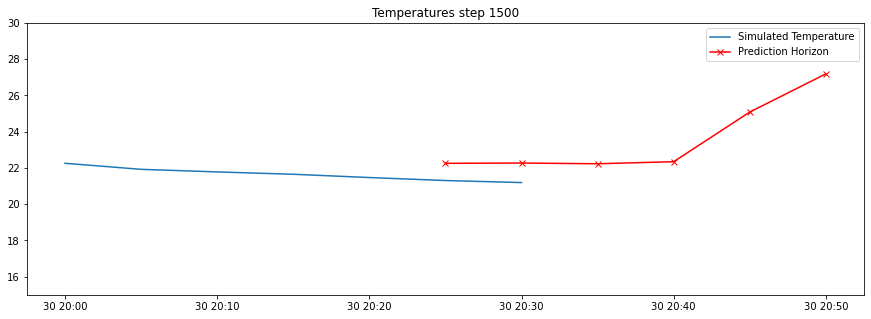

In [80]:
plt.figure(figsize = (15, 5))
plt.plot(df_simulation.index, df_simulation['values'], label = 'Simulated Temperature')
plt.plot(df_T_sim_horizon.index, df_T_sim_horizon['values'], label = 'Prediction Horizon', color = 'red', marker = 'x')
#plt.plot(df.index, df['InsideTemp'], label = 'Inside Temperature')
#plt.plot(df.index, df['OutsideTemp'], label = 'Outside Temperature')
plt.title(f'Temperatures step {current_timestamp}')
plt.legend()
plt.ylim((15, 30))
plt.savefig(f"sim_{current_timestamp}.png")
plt.show()


In [81]:
for loop_idx in range(100):
    current_timestamp = 1500 + 300*loop_idx
    print(f"Timestamp {current_timestamp}")
    
    u_1 = float(df_power.loc[df['time'] == (current_timestamp - 300 * 1), 'Heat'])
    u_2 = float(df_power.loc[df['time'] == (current_timestamp - 300 * 2), 'Heat'])

    y_1 = float(df.loc[df['time'] == (current_timestamp - 300 * 1), 'SimulatedTemp'])
    y_2 = float(df.loc[df['time'] == (current_timestamp - 300 * 2), 'SimulatedTemp'])
    y_3 = float(df.loc[df['time'] == (current_timestamp - 300 * 3), 'SimulatedTemp'])
    
    real_x0 = np.array([u_1, u_2, y_1, y_2, y_3])
    iter_idx = (df['time'] >= current_timestamp)
    real_W = df[iter_idx].iloc[:N_horizon, [5, 2]].to_numpy()

    real_p = casadi.vertcat(
        casadi.vec(real_W),
        casadi.vec(real_x0)
    )

    res = solver(p = real_p, lbg = real_lbg, ubg = real_ubg)
    
    df_power.loc[df_power['time'] == current_timestamp, 'Heat'] = res['x'].reshape((N_horizon, -1))[1, 2]
    
    power = np.array(df_power[['time', 'Heat']].dropna())
    eng.workspace['power'] = matlab.double(power.tolist())
    eng.set_param('polydome', 'StopTime', str(current_timestamp + 300), nargout = 0)
    eng.workspace['result'] = eng.sim('polydome')
    
    
    dict_simulation = {}
    dict_simulation['values'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
    dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)
    
    df_simulation = pd.DataFrame(dict_simulation)
    #df_simulation['time'] = df_simulation['time'].astype(int)
    df_simulation.set_index('time', inplace = True, drop = True)
    
    df_simulation['timestamp'] = df.index[0] + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))
    df_simulation = df_simulation.reset_index().set_index('timestamp')
    df_resampled_5 = df_simulation['values'].resample('5min').mean().pad()
    df_simulation = pd.concat([df['time'], df_resampled_5], axis = 1)
    
    df.loc[:, 'SimulatedTemp'] = df_simulation['values']
    T_sim_horizon = np.array(gpr(res['x'].reshape((N_horizon, -1)).T))
    simul_idx = (df_simulation['time'] >= current_timestamp) & (df_simulation['time'] < (current_timestamp + N_horizon * 300))
    
    
    df_T_sim_horizon = df_simulation[simul_idx].copy()
    df_T_sim_horizon.loc[:, 'values'] = T_sim_horizon.reshape((-1, ))
    
    plt.figure(figsize = (15, 5))
    plt.plot(df_simulation.index, df_simulation['values'], label = 'Simulated Temperature')
    plt.plot(df_T_sim_horizon.index, df_T_sim_horizon['values'], label = 'Prediction Horizon', color = 'red', marker = 'x')
    #plt.plot(df.index, df['InsideTemp'], label = 'Inside Temperature')
    #plt.plot(df.index, df['OutsideTemp'], label = 'Outside Temperature')
    plt.title(f'Temperatures step {current_timestamp}')
    plt.ylim((15, 30))
    plt.legend()
    plt.savefig(f"sim_{current_timestamp}.png")

Timestamp 1500


RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 1 (p) has mismatching shape. Got 15-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 14-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)